# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student': "Zhou Xiao"}



%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy
import seaborn as sns

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, Activation,SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel('epoch')
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel('epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    
# define a function that help plot the learning curves of 2 or 3 histories.
def plot_different_histories(history_1, history_2, history_3, history_4=None, label_1='', label_2='', label_3='', label_4='',title=''):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 7))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel('epoch')
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel('epoch')
    if history_4==None:
        ax1.plot(history_1['loss'], label=label_1 + ' training',c='r')
        ax1.plot(history_1['val_loss'], label=label_1 + ' validation',c='r',linestyle='--')
        ax1.plot(history_2['loss'], label=label_2 + ' training',c='g')
        ax1.plot(history_2['val_loss'], label=label_2 + ' validation',c='g',linestyle='--')
        ax1.plot(history_3['loss'], label=label_3 + ' training',c='b')
        ax1.plot(history_3['val_loss'], label=label_3 + ' validation',c='b',linestyle='--')
        ax2.plot(history_1['acc'], label=label_1 + ' training',c='r')
        ax2.plot(history_1['val_acc'], label=label_1 + ' validation',c='r',linestyle='--')
        ax2.plot(history_2['acc'], label=label_2 + ' training',c='g')
        ax2.plot(history_2['val_acc'], label=label_2 + ' validation',c='g',linestyle='--')
        ax2.plot(history_3['acc'], label=label_3 + ' training',c='b')
        ax2.plot(history_3['val_acc'], label=label_3 + ' validation',c='b',linestyle='--')
    else:
        ax1.plot(history_1['loss'], label=label_1 + ' training',c='r')
        ax1.plot(history_1['val_loss'], label=label_1 + ' validation',c='r',linestyle='--')
        ax1.plot(history_2['loss'], label=label_2 + ' training',c='g')
        ax1.plot(history_2['val_loss'], label=label_2 + ' validation',c='g',linestyle='--')
        ax1.plot(history_3['loss'], label=label_3 + ' training',c='b')
        ax1.plot(history_3['val_loss'], label=label_3 + ' validation',c='b',linestyle='--')
        ax1.plot(history_4['loss'], label=label_4 + ' training',c='brown')
        ax1.plot(history_4['val_loss'], label=label_4 + ' validation',c='brown',linestyle='--')
        ax2.plot(history_1['acc'], label=label_1 + ' training',c='r')
        ax2.plot(history_1['val_acc'], label=label_1 + ' validation',c='r',linestyle='--')
        ax2.plot(history_2['acc'], label=label_2 + ' training',c='g')
        ax2.plot(history_2['val_acc'], label=label_2 + ' validation',c='g',linestyle='--')
        ax2.plot(history_3['acc'], label=label_3 + ' training',c='b')
        ax2.plot(history_3['val_acc'], label=label_3 + ' validation',c='b',linestyle='--')
        ax2.plot(history_4['acc'], label=label_4 + ' training',c='brown')
        ax2.plot(history_4['val_acc'], label=label_4 + ' validation',c='brown',linestyle='--')
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)


def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
np.random.seed(seed)
conversations=getRawDataFromFile()

In [3]:
import random
np.random.seed(seed)
random.sample(conversations, 2)

[['hi , i am joey and i have never drink alcohol in my life',
  'i am a 19 year old alcoholic',
  'oh wow , i major geology at alabama u . suffer from social anxiety',
  'i play baseball at college',
  'my girlfriend of 7 years is in another state',
  'that sucks you should go see her',
  'yeah i will during the holidays',
  'is it far far away ?',
  'well it takes a bus or a car to get there .',
  'do you know mike trout ?',
  'i wish i could get rid of my social anxiety . . .',
  'oh no i am sorry',
  'yeah , its been tough and feeling quite paranoid',
  'do you follow baseball at a ; ; ?',
  'no i do not follow baseball',
  'well then . . . i do i love it'],
 ['i make my living in a supermarket ,',
  'are you a cashier or stock person ?',
  'the supermarket is blue , that is my favorite color',
  'i am a yellow person myself . together we make green .',
  'i work in the bakery i make cupcakes , i love cupcakes',
  'i help plan weddings . such fun work i say .',
  'i am a big guy , g

# Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** The log-log figure is close to a line, and it conforms to the distribution by Zipf's law (not strictly).

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080.



### Word Dictionary

In [4]:
word_dict={}
for temp_conversation in conversations:
    for temp_sentence in temp_conversation:
        temp_words=temp_sentence.split(' ')
        for temp_word in temp_words:
            try:
                word_dict[temp_word]+=1
            except:
                word_dict[temp_word]=1

In [5]:
len(word_dict)

18673

### Bar plot of 75 most frequent words

In [6]:
most_freq_75=sorted(word_dict.items(), key=lambda item: item[1], reverse=True)[:75]

In [7]:
most_freq_75_count=[temp[1] for temp in most_freq_75]
most_freq_75_word=[temp[0] for temp in most_freq_75]

Text(0,0.5,'count of sorted words')

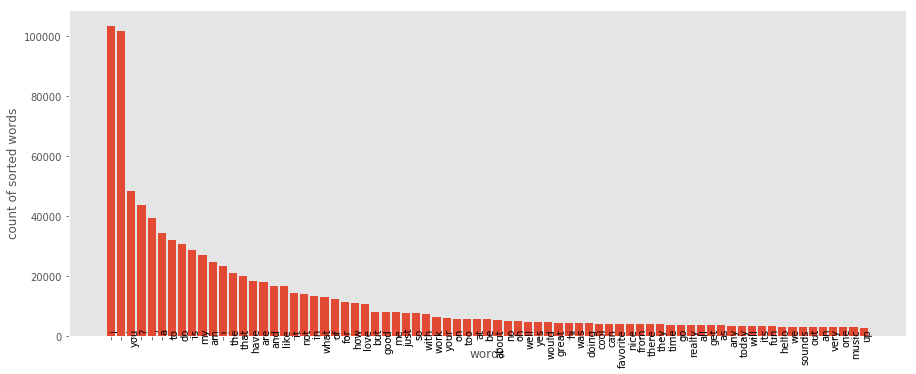

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15, 6))
rect=ax.bar(range(len(most_freq_75)), most_freq_75_count,tick_label='')
for name_num in range(len(most_freq_75_word)):
    ax.text(name_num-0.2,-10,most_freq_75_word[name_num],rotation=90)
ax.set_xlabel('words')
ax.set_ylabel('count of sorted words')

### Bar plot of 75 least frequent word

Text(0,0.5,'count of sorted words')

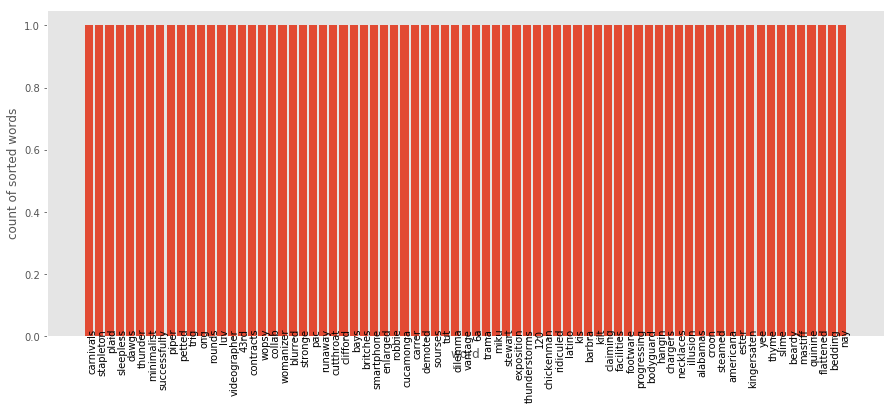

In [19]:
least_freq_75=sorted(word_dict.items(), key=lambda item: item[1])[:75]
least_freq_75_count=[temp[1] for temp in least_freq_75]
least_freq_75_word=[temp[0] for temp in least_freq_75]
fig, ax = plt.subplots(1,1,figsize=(15, 6))
rect=ax.bar(range(len(least_freq_75)), least_freq_75_count,tick_label='')
for name_num in range(len(least_freq_75_word)):
    ax.text(name_num-0.2,0,least_freq_75_word[name_num],rotation=90)
ax.set_xlabel('word')
ax.set_ylabel('count of sorted words')

### In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis)

Text(0,0.5,'count of sorted words')

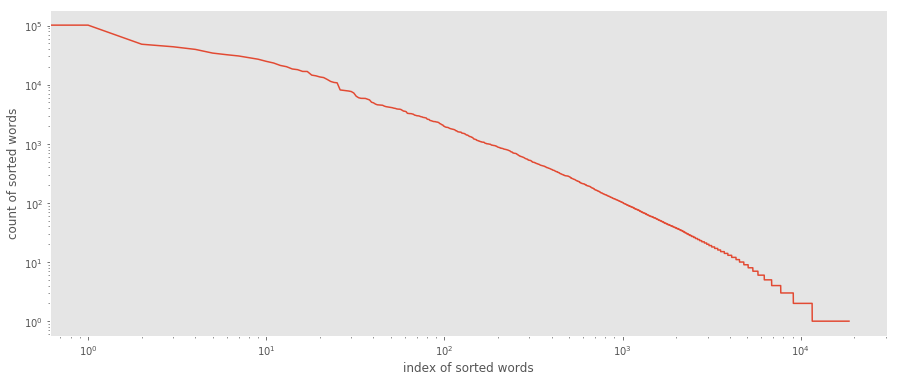

In [10]:
word_dict_sort=sorted(word_dict.items(), key=lambda item: item[1], reverse=True)
word_dict_sort_count=[temp[1] for temp in word_dict_sort]
word_dict_sort_index=range(len(word_dict_sort_count))
fig, ax = plt.subplots(1,1,figsize=(15, 6))
ax.plot(word_dict_sort_index, word_dict_sort_count)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('index of sorted words')
ax.set_ylabel('count of sorted words')

### How many words appear only once in the entire dataset

In [11]:
word_count_1=0
for temp_count in word_dict_sort:
    if temp_count[1]==1:
        word_count_1+=1
word_count_1

7080

# Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**:  Reduce word number from 18673 to 1007 (1010 if considering START, END, PADD) and preserve 50793 number of sentences as required in the task.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: filtered: 50793, original: 131424.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: In the dataset, if there are words that seldom exist in sentence, it can be seen as outliers or noise. As a result, these rare sentences may make our model overfit to the rare word and harder to generalize to other dataset . Thus, we remove the sentences with rare words, to make our model have a better learning performance and generalization ability.

### code for filtering

In [12]:
threshold=100
word_to_filter=[temp for temp in word_dict_sort if temp[1]<=threshold]
new_word_dict=dict([temp for temp in word_dict_sort if temp[1]>threshold])

In [13]:
word_to_filter_word=[temp[0] for temp in word_to_filter]
new_conversations=[]
for temp_conversation in conversations:
    new_conv=[]
    for temp_sentence in temp_conversation:
        if_rare=0
        temp_sentence_words=temp_sentence.split(' ')
        for temp_sentence_word in temp_sentence_words:   
            if temp_sentence_word in word_to_filter_word:
                if_rare=1
                break
                
        if if_rare==0:
            new_conv=new_conv+[temp_sentence]
            
    if new_conv!=[]:    
        new_conversations=new_conversations+[new_conv]

In [14]:
def count_sentence(data):
    cnt=0
    for temp_conversation in data:
        cnt+=len(temp_conversation)
    return cnt

In [15]:
print('The number of sentences in filter dataset is '+str(count_sentence(new_conversations)))
print('The number of sentences in origin dataset is '+str(count_sentence(conversations)))

The number of sentences in filter dataset is 50793
The number of sentences in origin dataset is 131424


In [16]:
new_sentences=[]
for temp_conversation in new_conversations:
    for temp_sentence in temp_conversation:
        new_sentences=new_sentences+[temp_sentence]

### How much did you reduce the number of unique words with your rare event suppression procedure?

In [17]:
print('The total number of words in original dataset is '+str(len(word_dict_sort)))
print('The number of words to be filtered is '+str(len(word_to_filter)))

The total number of words in original dataset is 18673
The number of words to be filtered is 17666


### How many sentences are in your filtered and original dataset?

In [18]:
def count_sentence(data):
    cnt=0
    for temp_conversation in data:
        cnt+=len(temp_conversation)
    return cnt

In [19]:
print('The number of sentences in filter dataset is '+str(count_sentence(new_conversations)))
print('The number of sentences in origin dataset is '+str(count_sentence(conversations)))

The number of sentences in filter dataset is 50793
The number of sentences in origin dataset is 131424


# Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

### Code for new dictionary and translation to lists of integers

In [20]:
token_word_dict=new_word_dict.copy()
temp_list=list(token_word_dict)
for temp_word in temp_list:
    token_word_dict[temp_word]=temp_list.index(temp_word)+1

In [21]:
token_word_dict['PADD']=0
token_word_dict['START']=len(temp_list)+1
token_word_dict['END']=len(temp_list)+2

In [22]:
# preserve conversation
final_conversations=[]
for temp_conversation in new_conversations:
    final_conv=[]
    for temp_sentence in temp_conversation:
        new_sentence=[]
        new_sentence=new_sentence+[token_word_dict['START']]
        temp_words=temp_sentence.split(' ')
        for temp_word in temp_words:
            map_word=token_word_dict[temp_word]
            new_sentence=new_sentence+[map_word]
        new_sentence=new_sentence+[token_word_dict['END']]
        final_conv=final_conv+[new_sentence]
    final_conversations=final_conversations+[final_conv]

In [23]:
# only sentence
final_sentences=[]
for temp_conversation in new_conversations:
    for temp_sentence in temp_conversation:
        new_sentence=[]
        new_sentence=new_sentence+[token_word_dict['START']]
        temp_words=temp_sentence.split(' ')
        for temp_word in temp_words:
            map_word=token_word_dict[temp_word]
            new_sentence=new_sentence+[map_word]
        new_sentence=new_sentence+[token_word_dict['END']]
        final_sentences=final_sentences+[new_sentence]

### violinplot to show the density of tokenized sentences length

In [24]:
sentence_len=[]
for temp_conversation in final_conversations:
    for temp_sentence in temp_conversation:
        temp_len=len(temp_sentence)
        sentence_len=sentence_len+[temp_len]

Text(0,0.5,'length of sentence')

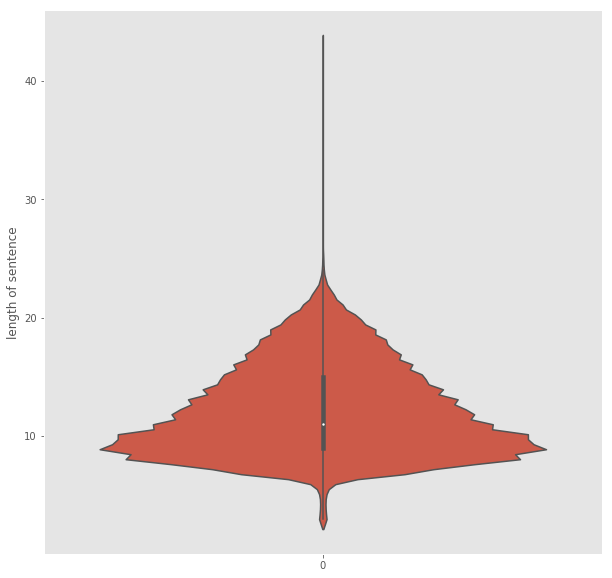

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
sns.violinplot(data=sentence_len)
ax.set_ylabel('length of sentence')

### Code for padding

In [26]:
maxlen=25
import keras.preprocessing.sequence as S
token=S.pad_sequences(final_sentences,maxlen,padding='post')
token[:3]

array([[1008,   72,  498,  783,  477,  682,   90,  537,  391,  931,  967,
         217,   99,  347,   90, 1009,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [1008,  664,  391,  136,   90,  663,   72,  530,  804,   99,  271,
         494,  505,  967,    6,  207, 1009,    0,    0,    0,    0,    0,
           0,    0,    0],
       [1008,  190,  391,  942,   99,  365,  706,  547,  207, 1009,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]])

### Check to recover the original sentence

In [28]:
inv_token_word_dict={v: k for k, v in token_word_dict.items()}

In [29]:
def recover_sentence(new_sentence):
    original_sentence=[]
    for temp_index in new_sentence:
        orignal_word=inv_token_word_dict[temp_index]
        if temp_index!=0:
            original_sentence=original_sentence+[orignal_word]
    return original_sentence

In [30]:
sentence_1, sentence_2=random.sample(list(token),2)
print('1st Sentence after preprocessing: ')
print(sentence_1)
print('1st Sentence after recovery: ')
print(recover_sentence(sentence_1))
print('--------------------------------------------------------------------------------------------------------')
print('2nd Sentence after preprocessing: ')
print(sentence_2)
print('2nd Sentence after recovery: ')
print(recover_sentence(sentence_2))

1st Sentence after preprocessing: 
[1008  613   72  247  207  530   72  204  247  207  918  258  207 1009
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
1st Sentence after recovery: 
['START', 'are', 'you', 'married', '?', 'have', 'you', 'been', 'married', '?', 'any', 'kids', '?', 'END']
--------------------------------------------------------------------------------------------------------
2nd Sentence after preprocessing: 
[1008  123  351  207 1009    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
2nd Sentence after recovery: 
['START', 'why', 'not', '?', 'END']


### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [31]:
import pickle

#save
with open("data_50000.pkl", "wb") as file:
    pickle.dump([new_conversations, new_sentences, token_word_dict, token], file)

### Importing Data

In [2]:
import pickle

#load
with open("data_50000.pkl", "rb") as file:
    [new_conversations, new_sentences, token_word_dict, token] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** The 'PADD' is also treated as a normal word to be classified upon the sequence of previous words in a sentence.
If the model is trained properly, the next word will be classified as 'PADD' once the previous word is a 'END' or 'PADD'.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**  Run the network by the previous words. For example, when calculating the probability of the nth word, the network will take into account the 1st, 2nd ...to the (n-1)th words.

Input: sentences with token;

Output: probability of corresponding position in sentence;

Input dimension: 2: number of sentences in batch, maxlen-1 ;

Output dimension: 3 : numer of sentences in batch,  maxlen-1,  vocabulary dictionary size

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**:  Best validation accuracy: LSTM; Fastest learner: GRU is the fastest to reach the final stable accuracy and RNN is fastest in each epoch.
(fastest learner can be observed more clearly by early stopping)

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: Yes, strictly speaking all 3 models have overfitting effect after about 10 epochs because the validation loss and accuracy do not improve anymore while training performance keep getting better, causing an increaing gap between training and validation performance.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: Increase more sentences for training or data augumentaion.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: Add dropout or batch normalization.

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: Use cross validation.

In [3]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.
readout_size=128
batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [4]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [5]:
maxlen=25
X=token
T=np.zeros((len(token), maxlen, len(token_word_dict)))     
for i in range(len(token)):
    for j in range(maxlen):
        temp_word_index=token[i][j]
        T[i][j][temp_word_index]=1

### Simple RNN

In [6]:
#Model suggestion

I['RNN'] = Input(shape=(maxlen-1,), name="input")
E['RNN'] = Embedding(len(token), embedding_size, mask_zero=True, name="embedding")(I['RNN'])

#your network here
H['RNN'] = SimpleRNN(hidden_size, activation='tanh', use_bias=True, dropout=dropout, recurrent_dropout=recurrent_dropout,
                      return_sequences=True)(E['RNN'])

#... Recurrent layer(s)

R['RNN'] = TimeDistributed(Dense(readout_size, activation='relu'), name='readout')(H['RNN'])
#... Readout
Y['RNN'] = Dense(units=len(token_word_dict),activation='softmax')(R['RNN'])
#... Output

models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
'''
logs['RNN'] = models['RNN'].fit({'input': X[:dataset_cut,:-1]}, {'output': X[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history
                                    '''
logs['RNN'] = models['RNN'].fit(  X[:dataset_cut,:-1], T[:dataset_cut,1:], 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history
#save
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['RNN'], file)
models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           6501504   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
dense_2 (Dense)              (None, 24, 1010)          130290    
Total params: 6,652,466
Trainable params: 6,652,466
Non-trainable params: 0
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [============================

In [7]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

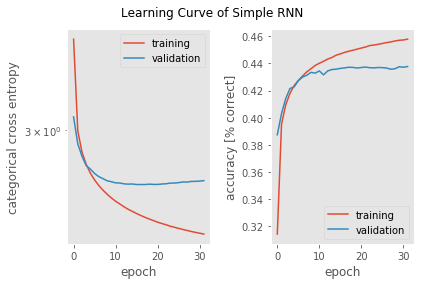

In [8]:
plot_history(logs['RNN'], 'Learning Curve of Simple RNN')

### LSTM

In [6]:
#Model suggestion

I['LSTM'] = Input(shape=(maxlen-1,), name="input")
E['LSTM'] = Embedding(len(token), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])

#your network here
H['LSTM'] = LSTM(hidden_size,  implementation=1, unit_forget_bias=True,
                 dropout=dropout, recurrent_dropout=recurrent_dropout,
                      return_sequences=True)(E['LSTM'])

#... Recurrent layer(s)

R['LSTM'] = TimeDistributed(Dense(readout_size, activation='relu'), name='readout')(H['LSTM'])
#... Readout
Y['LSTM'] = Dense(units=len(token_word_dict),activation='softmax')(R['LSTM'])
#... Output

models['LSTM'] = Model(inputs = [I['LSTM']], outputs = [Y['LSTM']])
models['LSTM'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['LSTM'].summary()

print(X[:,:-1].shape, T[:,1:].shape)

logs['LSTM'] = models['LSTM'].fit(  X[:dataset_cut,:-1], T[:dataset_cut,1:], 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history
#save
with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['LSTM'], file)
models['LSTM'].save("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           6501504   
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
dense_2 (Dense)              (None, 24, 1010)          130290    
Total params: 6,689,522
Trainable params: 6,689,522
Non-trainable params: 0
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [============================

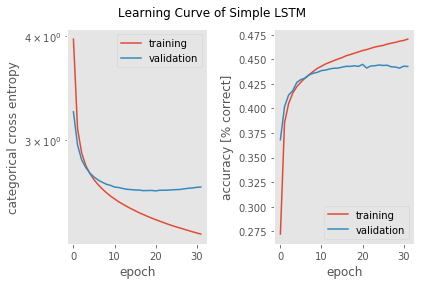

In [7]:
plot_history(logs['LSTM'], 'Learning Curve of Simple LSTM')

In [8]:
#load
with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    LSTMmodel_log = pickle.load(file)
LSTMmodel = load_model("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

### GRU

In [9]:
#Model suggestion

I['GRU'] = Input(shape=(maxlen-1,), name="input")
E['GRU'] = Embedding(len(token), embedding_size, mask_zero=True, name="embedding")(I['GRU'])

#your network here
H['GRU'] = GRU(hidden_size,  implementation=1, 
                 dropout=dropout, recurrent_dropout=recurrent_dropout,
                      return_sequences=True)(E['GRU'])

#... Recurrent layer(s)

R['GRU'] = TimeDistributed(Dense(readout_size, activation='relu'), name='readout')(H['GRU'])
#... Readout
Y['GRU'] = Dense(units=len(token_word_dict),activation='softmax')(R['GRU'])
#... Output

models['GRU'] = Model(inputs = [I['GRU']], outputs = [Y['GRU']])
models['GRU'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU'].summary()

print(X[:,:-1].shape, T[:,1:].shape)

logs['GRU'] = models['GRU'].fit(  X[:dataset_cut,:-1], T[:dataset_cut,1:], 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history
#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU'], file)
models['GRU'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           6501504   
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
dense_4 (Dense)              (None, 24, 1010)          130290    
Total params: 6,677,170
Trainable params: 6,677,170
Non-trainable params: 0
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [============================

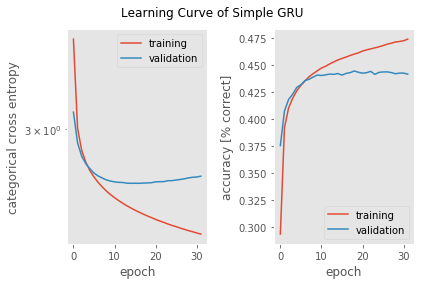

In [10]:
plot_history(logs['GRU'], 'Learning Curve of Simple GRU')

In [11]:
#load
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    GRUmodel_log = pickle.load(file)
GRUmodel = load_model("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

In [13]:
with open("RNNmodel_128_64_log.pkl", "rb") as file:
    logs['RNN'] = pickle.load(file)


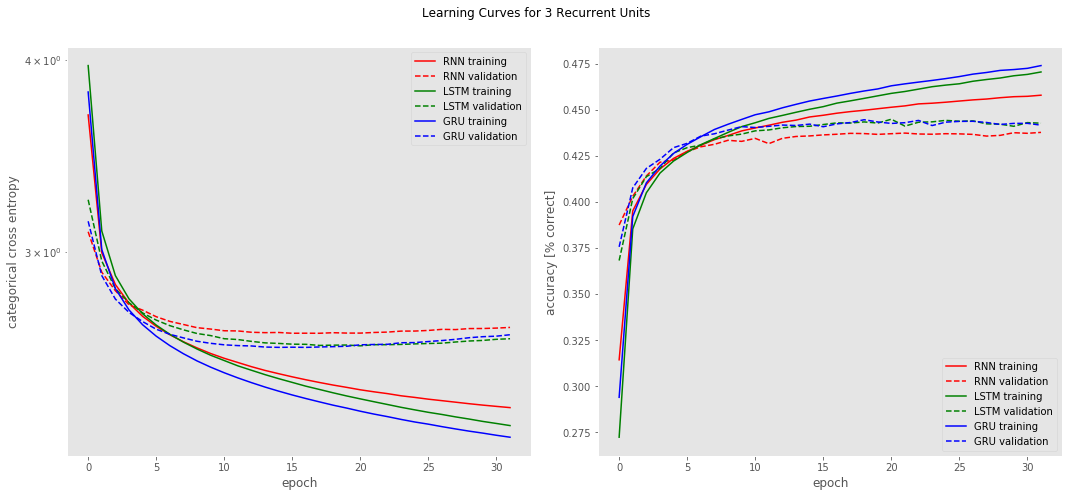

In [14]:
plot_different_histories(logs['RNN'],logs['LSTM'],logs['GRU'],label_1='RNN',label_2='LSTM',label_3='GRU',
                         title='Learning Curves for 3 Recurrent Units')

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**  Single-layer 256 GRUs takes most time in one epoch and consumes least epochs in this case, and early stopping is implemented after 9 epochs. Single-layer 128 GRUs and 2-layer 64 GRUs takes close training time before early stopping. Single-layer 128 GRUs has the  lowest loss on validation set while single-layer 256 GRUs has the highest validation accuracy. The shape of learning curves of these models are similar, and gap between training and validation set begins to show up after several epochs.

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** 

Pro: help with overfitting and reduce training time; 

Con: may not reach the best potential performance (accuracy in the case) due to local flutuations and cannot handle multi-task problem.

**Question** What is your best model? Why? [1 pt]

**Answer** In our case, single layer with 256 GRU is the best model because it has highest validation accuracy after training, although the difference among the models is not large.



In [15]:
LSTMmodel = load_model("LSTMmodel_128_64")
def new_GRU_model(hidden_size=64, hidden_layer=1):
    I= Input(shape=(maxlen-1,), name="input")
    # get embedding layer from previous model
    pretrained_embedding=LSTMmodel.get_layer('embedding')
    # transfer learning
    E= pretrained_embedding(I)
    H = GRU(hidden_size,  implementation=1, 
                 dropout=dropout, recurrent_dropout=recurrent_dropout,
                      return_sequences=True)(E)
    if hidden_layer==2:
        H = GRU(hidden_size,  implementation=1, 
                 dropout=dropout, recurrent_dropout=recurrent_dropout,
                      return_sequences=True)(H)
    R = TimeDistributed(Dense(readout_size, activation='relu'), name='readout')(H)
    
    Y = Dense(units=len(token_word_dict),activation='softmax')(R)
    model = Model(inputs =I, outputs =Y)
    model.compile(loss='categorical_crossentropy', 
                          optimizer=Adam(),metrics=['acc'])
    return model

def train_GRU(model,hidden_layer=1,hidden_size=64):
    early_stopping=EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2)
    log = model.fit(  X[:dataset_cut,:-1], T[:dataset_cut,1:], 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[early_stopping]).history
    with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_layer)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
        pickle.dump(logs['GRU'], file)
    model.save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_layer)+'_'+str(hidden_size))
    return model,log

In [16]:
GRUmodel_128=new_GRU_model(hidden_size=128, hidden_layer=1)
GRUmodel_128.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           6501504   
_________________________________________________________________
gru_2 (GRU)                  (None, 24, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           16512     
_________________________________________________________________
dense_6 (Dense)              (None, 24, 1010)          130290    
Total params: 6,746,994
Trainable params: 6,746,994
Non-trainable params: 0
_________________________________________________________________


In [17]:
GRUmodel_128, log_GRU_128 = train_GRU(GRUmodel_128,hidden_layer=1,hidden_size=128)

Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==============================] - 223s 5ms/step - loss: 3.3743 - acc: 0.3548 - val_loss: 2.8764 - val_acc: 0.4099
Epoch 2/32
40633/40633 [==============================] - 196s 5ms/step - loss: 2.7885 - acc: 0.4158 - val_loss: 2.7336 - val_acc: 0.4241
Epoch 3/32
40633/40633 [==============================] - 193s 5ms/step - loss: 2.6690 - acc: 0.4291 - val_loss: 2.6713 - val_acc: 0.4324
Epoch 4/32
40633/40633 [==============================] - 205s 5ms/step - loss: 2.5977 - acc: 0.4366 - val_loss: 2.6335 - val_acc: 0.4370
Epoch 5/32
40633/40633 [==============================] - 194s 5ms/step - loss: 2.5459 - acc: 0.4433 - val_loss: 2.6063 - val_acc: 0.4403
Epoch 6/32
40633/40633 [==============================] - 201s 5ms/step - loss: 2.5034 - acc: 0.4483 - val_loss: 2.5905 - val_acc: 0.4420
Epoch 7/32
40633/40633 [==============================] - 187s 5ms/step - loss: 2.4689 - acc: 0.4522 - val_loss: 2.5819 - 

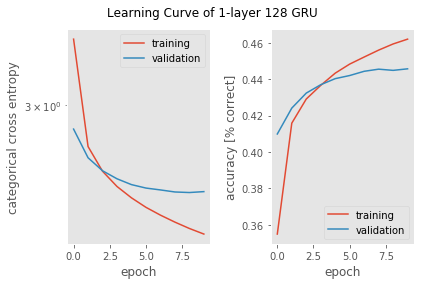

In [18]:
plot_history(log_GRU_128, 'Learning Curve of 1-layer 128 GRU')

In [19]:
GRUmodel_256=new_GRU_model(hidden_size=256, hidden_layer=1)
GRUmodel_256.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           6501504   
_________________________________________________________________
gru_3 (GRU)                  (None, 24, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           32896     
_________________________________________________________________
dense_8 (Dense)              (None, 24, 1010)          130290    
Total params: 6,960,370
Trainable params: 6,960,370
Non-trainable params: 0
_________________________________________________________________


In [20]:
GRUmodel_256, log_GRU_256 = train_GRU(GRUmodel_256,hidden_layer=1,hidden_size=256)

Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==============================] - 254s 6ms/step - loss: 3.2114 - acc: 0.3755 - val_loss: 2.7835 - val_acc: 0.4180
Epoch 2/32
40633/40633 [==============================] - 218s 5ms/step - loss: 2.6936 - acc: 0.4278 - val_loss: 2.6578 - val_acc: 0.4363
Epoch 3/32
40633/40633 [==============================] - 219s 5ms/step - loss: 2.5794 - acc: 0.4409 - val_loss: 2.6104 - val_acc: 0.4406
Epoch 4/32
40633/40633 [==============================] - 222s 5ms/step - loss: 2.5072 - acc: 0.4490 - val_loss: 2.5823 - val_acc: 0.4453
Epoch 5/32
40633/40633 [==============================] - 215s 5ms/step - loss: 2.4523 - acc: 0.4553 - val_loss: 2.5672 - val_acc: 0.4456
Epoch 6/32
40633/40633 [==============================] - 217s 5ms/step - loss: 2.4043 - acc: 0.4615 - val_loss: 2.5645 - val_acc: 0.4466
Epoch 7/32
40633/40633 [==============================] - 211s 5ms/step - loss: 2.3607 - acc: 0.4667 - val_loss: 2.5599 - 

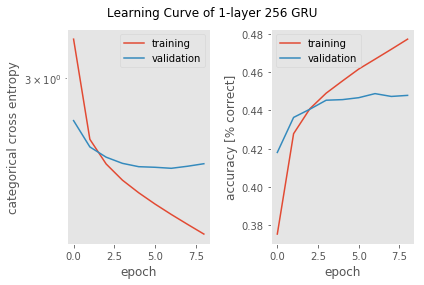

In [21]:
plot_history(log_GRU_256, 'Learning Curve of 1-layer 256 GRU')

In [22]:
GRUmodel_2_64=new_GRU_model(hidden_size=64, hidden_layer=2)
GRUmodel_2_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           6501504   
_________________________________________________________________
gru_4 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
gru_5 (GRU)                  (None, 24, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
dense_10 (Dense)             (None, 24, 1010)          130290    
Total params: 6,701,938
Trainable params: 6,701,938
Non-trainable params: 0
_________________________________________________________________


In [23]:
GRUmodel_2_64, log_GRU_2_64 = train_GRU(GRUmodel_2_64,hidden_layer=2,hidden_size=64)

Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==============================] - 252s 6ms/step - loss: 3.4807 - acc: 0.3399 - val_loss: 2.9303 - val_acc: 0.4034
Epoch 2/32
40633/40633 [==============================] - 204s 5ms/step - loss: 2.8280 - acc: 0.4126 - val_loss: 2.7672 - val_acc: 0.4191
Epoch 3/32
40633/40633 [==============================] - 186s 5ms/step - loss: 2.7046 - acc: 0.4260 - val_loss: 2.7034 - val_acc: 0.4289
Epoch 4/32
40633/40633 [==============================] - 206s 5ms/step - loss: 2.6373 - acc: 0.4336 - val_loss: 2.6635 - val_acc: 0.4332
Epoch 5/32
40633/40633 [==============================] - 200s 5ms/step - loss: 2.5892 - acc: 0.4388 - val_loss: 2.6383 - val_acc: 0.4360
Epoch 6/32
40633/40633 [==============================] - 203s 5ms/step - loss: 2.5520 - acc: 0.4428 - val_loss: 2.6234 - val_acc: 0.4390
Epoch 7/32
40633/40633 [==============================] - 201s 5ms/step - loss: 2.5210 - acc: 0.4463 - val_loss: 2.6101 - 

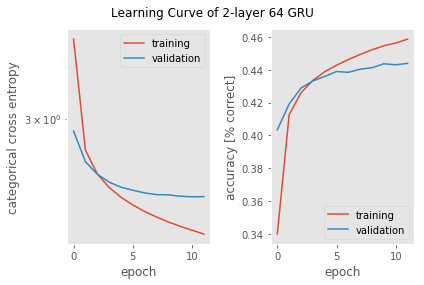

In [24]:
plot_history(log_GRU_2_64, 'Learning Curve of 2-layer 64 GRU')

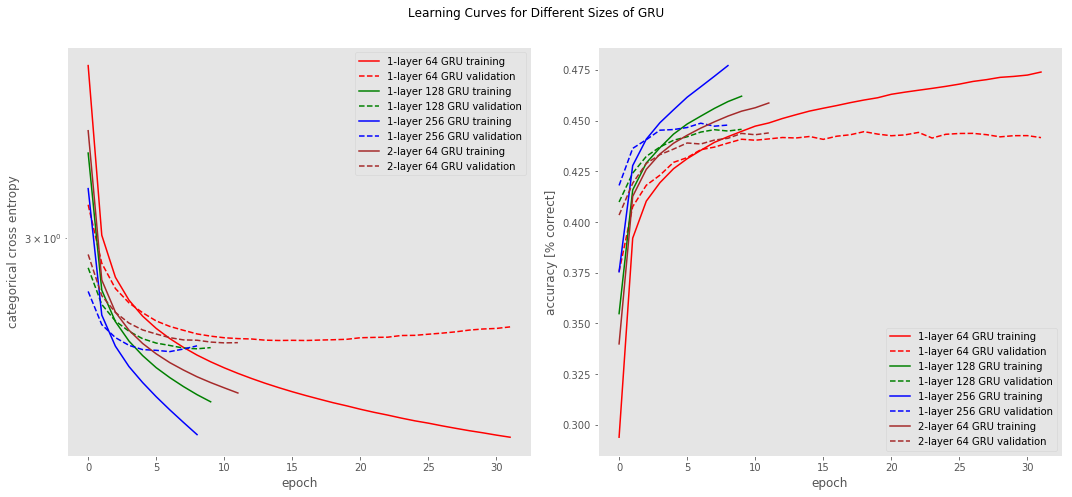

In [25]:
plot_different_histories(GRUmodel_log,log_GRU_128,log_GRU_256, history_4=log_GRU_2_64,
                         label_1='1-layer 64 GRU',label_2='1-layer 128 GRU',label_3='1-layer 256 GRU',label_4='2-layer 64 GRU',
                         title='Learning Curves for Different Sizes of GRU')

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Larger sampling temperature will leads to more randomness.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** No randomness, the result conforms strictly to the word with highest probability without flexibility.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** Close to Gaussian distribution of the probability of predicted next potential words.

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** High randomness, the result may comes from the word without a high probability. In lack of training data, it may cause that the generated sentence is not correct. With enough training data, it can bring more flexibility.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**  Based on the probability distribution of next predicted word. If the sampling temperature is low, for example, 0, the generated word is exactly the word with highest probability after implement the trained network. With higher sampling temperature, it will take more words in account, but concerning probability, it is still based on the prediction among most probable words. Also, if the current word is not chosen with highest probability, the next predcited word can have many choices, which mean that more words turn to have a high probability.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Yes, especially in high sampling temperature, the word is predicted among some highest probabilities. We assume it's reasonable in language processing as long as the generated sentence is correct. For example, when we start with "i like" in a sentence, there is no reason the third word should be limited to small range of choices, which lack flexibility and generalization.

In [26]:
import pickle

#load
with open("data_50000.pkl", "rb") as file:
    [new_conversations, new_sentences, token_word_dict, token] = pickle.load(file)
maxlen=25

In [27]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [28]:
# Best: 1-layer 256 GRU
GRUmodel_256 = load_model("GRUmodel_128_1_256")
GRUmodel_128 = load_model("GRUmodel_128_1_128")

In [29]:
maxlen=len(token[0])
inv_token_word_dict={v: k for k, v in token_word_dict.items()}
def recover_sentence(new_sentence):
    original_sentence=[]
    for temp_index in new_sentence:
        orignal_word=inv_token_word_dict[temp_index]
        if temp_index!=0:
            original_sentence=original_sentence+[orignal_word]
    return original_sentence

In [30]:
init_sentence=np.array([token_word_dict['START']]+(maxlen-2)*[token_word_dict['PADD']])
init_sentence=init_sentence.reshape((1,maxlen-1))

In [31]:
def generate_10_sentences(temperature=0,init_sentence=init_sentence,model=GRUmodel_256,start=1):
    print('With Temperature '+str(temperature))
    for i in range(10):
        temp_sentence=init_sentence.copy()
        sentence=[token_word_dict['START']]
        for word_index in range(start,maxlen-1):
            temp_pred=model.predict(temp_sentence)
            temp_word_token=sample(temp_pred[0][word_index],temperature=temperature)
            temp_sentence[0][word_index]=temp_word_token
        original_sentence=recover_sentence(temp_sentence[0])
        print("Sample "+str(i+1))
        print('Token Sentence '+str(temp_sentence[0]))
        print('Origianl Sentence '+ str(original_sentence))
    return temp_sentence

In [32]:
def plot_word_prob(temp_sentence,model=GRUmodel_256):
    temp_pred=model.predict(temp_sentence)
    
    words_in_sentence=[]
    for temp_word in temp_sentence[0]:
        #print(temp_word)
        if temp_word in words_in_sentence:
            continue
        else:
            words_in_sentence=words_in_sentence+[temp_word]
            
    X=np.zeros((len(words_in_sentence),maxlen-1))
    for time_step in range(1,maxlen):
        for i in range(len(words_in_sentence)):
            X[i][time_step-1]=temp_pred[0][time_step-1][words_in_sentence[i]]
    plt.xticks(np.arange(maxlen)+0.5,range(1,maxlen))
    original_word_list=[inv_token_word_dict[word_index] for word_index in words_in_sentence]
    plt.yticks(np.arange(len(words_in_sentence))-0.5,original_word_list)

    plt.imshow(X, cmap = 'Greys')


### We plot the probability of each word in the last sentence of 10 generated sentences.

With Temperature 0
Sample 1
Token Sentence [1008  219  179  541   90  904  613   72  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'good', '.', 'how', 'are', 'you', '?', 'END']
Sample 2
Token Sentence [1008  219  179  541   90  904  613   72  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'good', '.', 'how', 'are', 'you', '?', 'END']
Sample 3
Token Sentence [1008  219  179  541   90  904  613   72  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'good', '.', 'how', 'are', 'you', '?', 'END']
Sample 4
Token Sentence [1008  219  179  541   90  904  613   72  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'good', '.', 'how', 'are', 'you', '?', 'END']
Sample 5
Token Sentence [1008  219  179  541   90  90

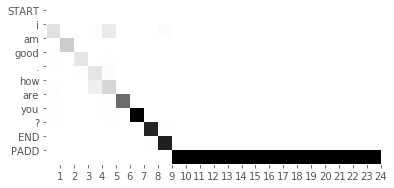

In [33]:
init_sentence=np.array([token_word_dict['START']]+(maxlen-2)*[token_word_dict['PADD']])
init_sentence=init_sentence.reshape((1,maxlen-1))
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=0,start=1)
plot_word_prob(temp_sentence)

With Temperature 0.25
Sample 1
Token Sentence [1008  219  179  541   90  904  613   72  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'good', '.', 'how', 'are', 'you', '?', 'END']
Sample 2
Token Sentence [1008  219  179  541   90  904  613   72  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'good', '.', 'how', 'are', 'you', '?', 'END']
Sample 3
Token Sentence [1008  219  179  541   90  904  613   72  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'good', '.', 'how', 'are', 'you', '?', 'END']
Sample 4
Token Sentence [1008  219  179  675  976   90  904    9   72  207 1009    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'doing', 'great', '.', 'how', 'about', 'you', '?', 'END']
Sample 5
Token Sentence [1008  219  17

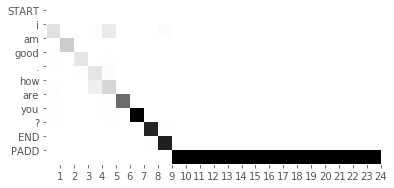

In [34]:
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=0.25,start=1)
plot_word_prob(temp_sentence)

With Temperature 0.5
Sample 1
Token Sentence [1008  219  179  541  663   72  621 1009    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'good', 'do', 'you', 'work', 'END']
Sample 2
Token Sentence [1008  219  179  675  541   90  904  613   72  207 1009    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'doing', 'good', '.', 'how', 'are', 'you', '?', 'END']
Sample 3
Token Sentence [1008  219  179  675  403  715  904    9   72  207 1009    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'doing', 'well', ',', 'how', 'about', 'you', '?', 'END']
Sample 4
Token Sentence [1008  219  179  976  715   38  526  191   25  217  687  970   90 1009
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'am', 'great', ',', 'just', 'got', 'done', 'with', 'my', 'two', 'sons', '.', 'END']
Sample 5


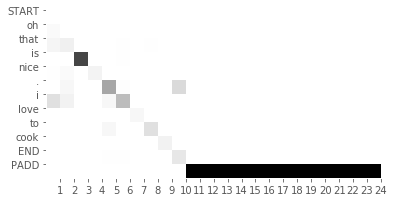

In [35]:
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=0.5,start=1)
plot_word_prob(temp_sentence)

With Temperature 0.75
Sample 1
Token Sentence [1008   72   86  290  207  219  530  931   90 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'you', 'like', 'rap', '?', 'i', 'have', 'one', '.', 'END']
Sample 2
Token Sentence [1008  351  640   90  904    9   72  207 1009    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'not', 'yet', '.', 'how', 'about', 'you', '?', 'END']
Sample 3
Token Sentence [1008  541  663   72  530  918  574 1009    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'good', 'do', 'you', 'have', 'any', 'pets', 'END']
Sample 4
Token Sentence [1008  190  663   72  663  943  804  249  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'what', 'do', 'you', 'do', 'for', 'a', 'living', '?', 'END']
Sample 5
Token Sentence [1008  341  947  904  613   7

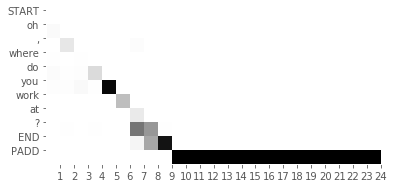

In [36]:
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=0.75,start=1)
plot_word_prob(temp_sentence)

With Temperature 1
Sample 1
Token Sentence [1008  408  109  947  904  613   72  207 1009    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'hello', 'there', '!', 'how', 'are', 'you', '?', 'END']
Sample 2
Token Sentence [1008  341   90  219  179  136  773   72  207 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'hi', '.', 'i', 'am', 'awesome', 'and', 'you', '?', 'END']
Sample 3
Token Sentence [1008  217  482  773  585  258  773  804  218   90 1009    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'my', 'dog', 'and', '2', 'kids', 'and', 'a', 'guitar', '.', 'END']
Sample 4
Token Sentence [1008  141  947  663   72   86  112  207 1009    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'yes', '!', 'do', 'you', 'like', 'football', '?', 'END']
Sample 5
Token Sentence [1008  663   72   

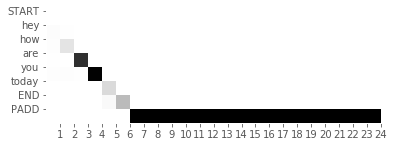

In [37]:
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=1,start=1)
plot_word_prob(temp_sentence)

With Temperature 1.5
Sample 1
Token Sentence [1008  141  352  391  477  626  347  663   72  522 1009    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'yes', 'which', 'is', 'very', 'cool', 'hobbies', 'do', 'you', 'draw', 'END']
Sample 2
Token Sentence [1008  219  844  904  217  602  876  558  559   90 1009    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'believe', 'how', 'my', 'hate', 'myself', 'love', 'makeup', '.', 'END']
Sample 3
Token Sentence [1008  791  495  385  511  423  932   90  910  505  967  488 1009    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'growing', 'vegetables', 'in', 'the', 'movies', 'now', '.', 'long', 'time', 'of', 'band', 'END']
Sample 4
Token Sentence [1008  408   90  904  391   15  636  111  454 1009    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'hello', '.', 'how', 'is', '

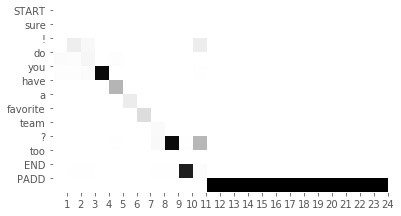

In [38]:
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=1.5,start=1)
plot_word_prob(temp_sentence)

With Temperature 2.0
Sample 1
Token Sentence [1008  670  407    2  469  617  715 1009    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'once', 'before', 'again', 'past', 'boring', ',', 'END']
Sample 2
Token Sentence [1008  909  391  796  434  505  706  366   72  633 1009    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'nursing', 'is', 'new', 'on', 'time', 'to', 'walk', 'you', 'online', 'END']
Sample 3
Token Sentence [1008   73  615  391  379 1005  980  585  523  596  947 1009    0    0
    0    0    0    0    0    0  664  933   90  955]
Origianl Sentence ['START', 'so', 'hiking', 'is', 'wonderful', 'besides', 'american', '2', 'dogs', 'spent', '!', 'END', 'that', 'sad', '.', 'trying']
Sample 4
Token Sentence [1008  395   88  266  391  190  663  613  511  116  749 1009    0    0
    0    0    0  219  159  351  696  706  663  914]
Origianl Sentence ['START', 'no', 'at', 'it', 'is', 

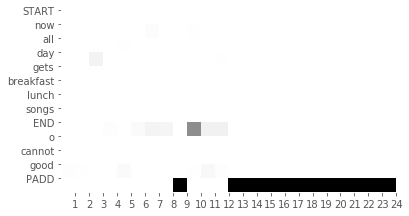

In [39]:
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=2.0,start=1)
plot_word_prob(temp_sentence)

With Temperature 1
Sample 1
Token Sentence [1008  219   86  387  480  219  810  695  931  967  328 1009    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'like', 'music', 'maybe', 'i', 'can', 'get', 'one', 'of', 'some', 'END']
Sample 2
Token Sentence [1008  219   86  699  461  373  947  213  894  391  964  330   86  365
   90 1009    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'like', 'pop', 'country', 'too', '!', 'really', 'mine', 'is', 'purple', 'especially', 'like', 'meat', '.', 'END']
Sample 3
Token Sentence [1008  219   86  358  552   97  943  217  116  721  530  706 1009    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'i', 'like', 'school', 'but', 'ask', 'for', 'my', 'family', 'we', 'have', 'to', 'END']
Sample 4
Token Sentence [1008  219   86  627  148   90  585  272   36  804  257   36  804  429
  773  663  351  530  505   90 1009    0    0    0]
Origianl Sentence ['START

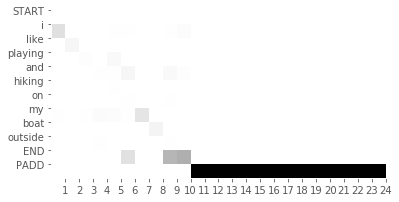

In [40]:
init_sentence=np.array([token_word_dict['START']]+[token_word_dict['i']]+[token_word_dict['like']]+(maxlen-4)*[token_word_dict['PADD']])
init_sentence=init_sentence.reshape((1,maxlen-1))
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=1,start=3)
plot_word_prob(temp_sentence)

With Temperature 1
Sample 1
Token Sentence [1008  190  391  739   25   72  207  207 1009    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'what', 'is', 'wrong', 'with', 'you', '?', '?', 'END']
Sample 2
Token Sentence [1008  190  391  942   99   70  207 1009    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'what', 'is', 'your', 'favorite', 'fruit', '?', 'END']
Sample 3
Token Sentence [1008  190  391  664  664   86  664  207 1009    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'what', 'is', 'that', 'that', 'like', 'that', '?', 'END']
Sample 4
Token Sentence [1008  190  391  942   99  107  207 1009    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Origianl Sentence ['START', 'what', 'is', 'your', 'favorite', 'color', '?', 'END']
Sample 5
Token Sentence [1008  190  391  942   83  776  20

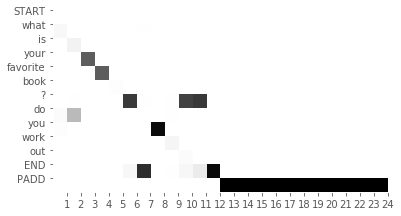

In [41]:
init_sentence=np.array([token_word_dict['START']]+[token_word_dict['what']]+[token_word_dict['is']]+(maxlen-4)*[token_word_dict['PADD']])
init_sentence=init_sentence.reshape((1,maxlen-1))
temp_sentence=generate_10_sentences(init_sentence=init_sentence,temperature=1,start=3)
plot_word_prob(temp_sentence)

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer** 

Yes.

1. 'am', 'is', 'are', 'be', 'been' are close;

2. 'in', 'on', 'at', 'from', 'to' are close;

3. Words representing for appreciation, like 'like', 'love' and 'enjoy' are also close.

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** Having similar vector representation for similar words can mean that the weights of embedding layer as well as recurrent layer are trained properly. For example, the words 'like', 'love' and 'enjoy' mentioned above have close vector representation and thus share close probability in word prediction. In many situations, they can replace each other (e.g. i like/love/enjoy music.), and this may provide more flexible generations of sentences, and reduce overfitting problem. Therefore, we assume it leads to better generalization ability.

In [42]:
from sklearn.manifold import TSNE
import pickle

#load
GRUmodel_256 = load_model("GRUmodel_128_1_256")
GRUmodel_128 = load_model("GRUmodel_128_1_128")
with open("data_50000.pkl", "rb") as file:
    [new_conversations, new_sentences, token_word_dict, token] = pickle.load(file)
inv_token_word_dict={v: k for k, v in token_word_dict.items()}
maxlen=25

In [43]:
best_embedding=GRUmodel_256.get_layer('embedding')
def get_embedding_weight(word):
    temp_sentence=np.array((maxlen-1)*[token_word_dict[word]])
    temp_sentence=temp_sentence.reshape((1,maxlen-1))
    I= Input(shape=(maxlen-1,), name="input")
    E= best_embedding(I)
    model = Model(inputs =I, outputs =E)
    temp_pred=model.predict(temp_sentence)
    word_weight=temp_pred[0][0]
    return word_weight

In [44]:
word_count_dict={}
for temp_sentence in token:
        for temp_word in temp_sentence:
            try:
                word_count_dict[temp_word]+=1
            except:
                word_count_dict[temp_word]=1
freq_200_token_count=sorted(word_count_dict.items(), key=lambda item: item[1], reverse=True)[:200]

In [45]:
freq_200_word_list=[]
for temp_tuple in freq_200_token_count:
    temp_word_token=temp_tuple[0]
    temp_word=inv_token_word_dict[temp_word_token]
    freq_200_word_list.append(temp_word)

In [46]:
def get_words_weights(temp_list):
    word_weight_dict={}
    for temp_word in temp_list:
        word_weight=get_embedding_weight(temp_word)
        word_weight_dict[temp_word]=word_weight
    return word_weight_dict

In [47]:
word_weight_dict=get_words_weights(freq_200_word_list)
word_weight_dict['is']

array([-0.34357658, -0.04885668,  0.23115301, -0.01433465,  0.19438908,
       -0.21848057,  0.08814952, -0.42085662,  0.28079942, -0.26201704,
        0.048603  ,  0.25282338,  0.11922061, -0.06254931, -0.05264784,
       -0.24374454, -0.30380002,  0.23870164,  0.04521691, -0.07181227,
       -0.0910798 , -0.22327407,  0.07751135, -0.19391912,  0.26139054,
        0.05907761,  0.2460265 ,  0.13128547, -0.2870773 ,  0.3238514 ,
       -0.1467068 , -0.4754028 , -0.08883688, -0.33262336,  0.15444365,
       -0.22299598, -0.10500917, -0.3030126 ,  0.25986144,  0.30567172,
       -0.05062173, -0.3458513 , -0.0521159 ,  0.38078555,  0.1346667 ,
        0.13344707,  0.1568867 , -0.09262089, -0.13548486, -0.12190092,
       -0.36670497,  0.10147256, -0.32703534, -0.12180584, -0.38530397,
       -0.04516615,  0.02818104,  0.1267102 , -0.03341833,  0.311974  ,
       -0.26141122, -0.03189867, -0.0123626 ,  0.41222307,  0.00245727,
        0.24107726, -0.42810723, -0.01036147,  0.1499697 ,  0.01

In [48]:
word_200_list=list(word_weight_dict)
weight_200_list=list(word_weight_dict.values())

In [49]:
tsne=TSNE()
tsne.fit_transform(weight_200_list)
tsne_200_list=tsne.embedding_

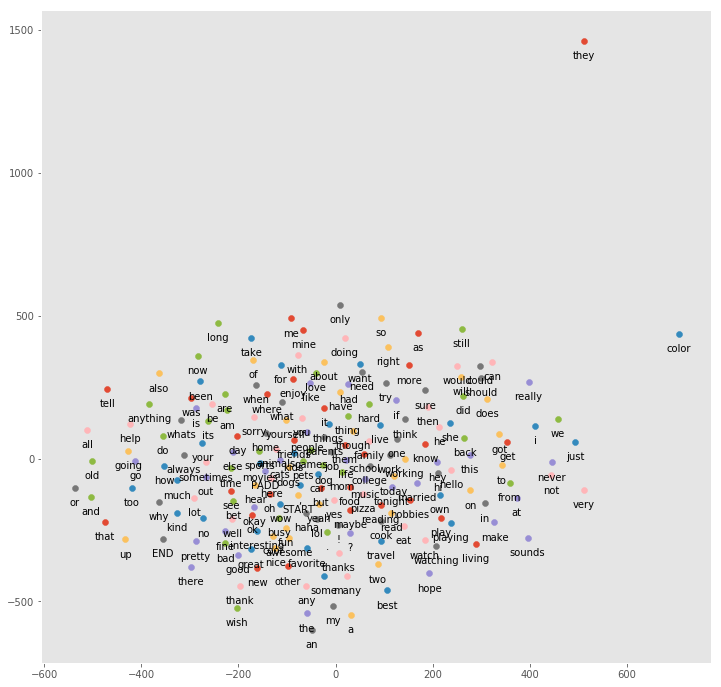

In [50]:
fig, ax = plt.subplots(1,1,figsize=(12, 12))
for i in range(200):
    temp_word= word_200_list[i]
    temp_x=tsne_200_list[i][0]
    temp_y=tsne_200_list[i][1]
    ax.scatter(temp_x,temp_y)
    ax.annotate(
        temp_word,
        xy=(temp_x, temp_y),
        xytext=(0, -10),
        textcoords='offset points',
        ha='center',
        va='top')

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer** With low sampling temperature, it's quite close to the real answers but also has a risk of overfitting, which is that the probability of a predicted word is based on the word in context and previous words in the answer. Our model can give some probable answers but also some unreasonable answers. The answers for greeting are mostly reasonable because there are lots of Q&A concerning greetings in the training set. Here we list good and bad example, according to the printed answer to "i was, but my wife left me when i was in the military" below with sampling temperature below. Good answer: "i am sorry to hear that", which is exactly the same as the real answer in dataset. Bad answer: "happy birthday, where are you from".

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**  With few training data, low sampling temperature may be better because it can improve the situation that the sentence is not complete or the answer does not correspond to the context, but it also may cause overfitting problem. With enough training data, we assume a properly high sampling temperature (e.g. 1) is better, because it can provide more flexibility and promote flexible conversations if it's trained to generate complete answer sentence and correspond to the context.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** No, it may refer to overfitting and lack ability of generalization.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [51]:
original_converssations=getRawDataFromFile()

In [52]:
all_quest_answ=[]
for temp_conversation in original_converssations:
    for i in range(len(temp_conversation)):
        try:
            temp_quest=temp_conversation[i]
            temp_answ=temp_conversation[i+1]
            temp_quest_answ=[temp_quest]+[temp_answ]
            all_quest_answ.append(temp_quest_answ)
        except:
            continue

In [53]:
import random
np.random.seed(seed)
random.sample(all_quest_answ, 2)

[['are you selling them , i would happily purchase one',
  'yes , they cost 1 , 000 each . how many do you want ?'],
 ['hey there hows it going tonight ?',
  'really great . jamming out to the muggers']]

### Filtering: According to previous filtered word dictionary, we can preserve about 51,000 single sentences but less than 25,000 pairs of question and answers. Thus we decide to rebuild a new filtered dictionary to preserve more QA in this section.

In [54]:
word_dict={}
for temp_qa in all_quest_answ:
    temp_quest=temp_qa[0]
    temp_quest_words=temp_quest.split(' ')
    temp_answ=temp_qa[1]
    temp_answ_words=temp_answ.split(' ')
    for temp_word in temp_quest_words:
        try:
            word_dict[temp_word]+=1
        except:
            word_dict[temp_word]=1
    for temp_word in temp_answ_words:
        try:
            word_dict[temp_word]+=1
        except:
            word_dict[temp_word]=1
        

In [55]:
threshold=100
word_dict_sort=sorted(word_dict.items(), key=lambda item: item[1], reverse=True)
word_to_filter=[temp for temp in word_dict_sort if temp[1]<=threshold]
new_word_dict=dict([temp for temp in word_dict_sort if temp[1]>threshold])

In [56]:
word_to_filter_word=[temp[0] for temp in word_to_filter]
filter_quest_answ=[]
for temp_qa in all_quest_answ:
    if_rare=0
    temp_quest_words=temp_qa[0].split(' ')
    temp_answ_words=temp_qa[1].split(' ')
    for temp_quest_word in temp_quest_words:   
        if temp_quest_word in word_to_filter_word:
            if_rare=1
            break
    for temp_answ_word in temp_answ_words:   
        if temp_answ_word in word_to_filter_word:
            if_rare=1
            break   
                
    if if_rare==0:
        filter_quest_answ.append(temp_qa)


In [57]:
print('The number of preserved words is '+str(len(new_word_dict)))
print('The number of paris of Q&A in filter dataset is '+str(len(filter_quest_answ)))

The number of preserved words is 1571
The number of paris of Q&A in filter dataset is 31837


### Tokenization and padding

In [58]:
qa_word_dict=new_word_dict.copy()
temp_list=list(qa_word_dict)
for temp_word in temp_list:
    qa_word_dict[temp_word]=temp_list.index(temp_word)+1
qa_word_dict['PADD']=0
qa_word_dict['START']=len(temp_list)+1
qa_word_dict['END']=len(temp_list)+2

In [59]:
token_quest_answ=[]
for temp_qa in filter_quest_answ:
    temp_quest_list=[]
    temp_answ_list=[]
    temp_answ_list=temp_answ_list+[qa_word_dict['START']]
    temp_quest=temp_qa[0]
    temp_answ=temp_qa[1]
    temp_q_words=temp_quest.split(' ')
    temp_a_words=temp_answ.split(' ')
    for temp_word in temp_q_words:
        map_word=qa_word_dict[temp_word]
        temp_quest_list=temp_quest_list+[map_word]
    for temp_word in temp_a_words:
        map_word=qa_word_dict[temp_word]
        temp_answ_list=temp_answ_list+[map_word]
    temp_answ_list=temp_answ_list+[qa_word_dict['END']]
    token_quest_answ.append([temp_quest_list]+[temp_answ_list])

Max sentence length in Q&A is 31


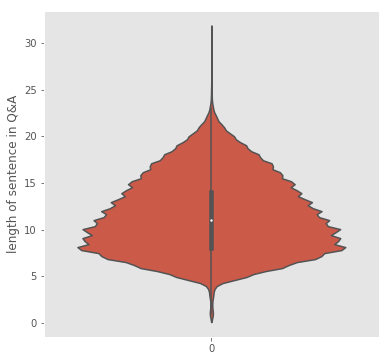

In [60]:
qa_sentence_len=[]
for temp_qa in token_quest_answ:
    temp_quest_len=len(temp_qa[0])
    qa_sentence_len=qa_sentence_len+[temp_quest_len]
    temp_answ_len=len(temp_qa[1])
    qa_sentence_len=qa_sentence_len+[temp_answ_len]
fig, ax = plt.subplots(1,1,figsize=(6, 6))
sns.violinplot(data=qa_sentence_len)
ax.set_ylabel('length of sentence in Q&A')
print('Max sentence length in Q&A is '+str(max(np.array(qa_sentence_len))))

In [61]:
maxlen=25
token_quest=[qa[0] for qa in token_quest_answ]
token_answ=[qa[1] for qa in token_quest_answ]
import keras.preprocessing.sequence as S
token_quest=S.pad_sequences(token_quest,maxlen,padding='post')
token_answ=S.pad_sequences(token_answ,maxlen,padding='post')
token_quest_answ=[[token_quest[i],token_answ[i]] for i in range(len(token_quest)) ]

In [62]:
inv_qa_word_dict={v: k for k, v in qa_word_dict.items()}
def recover_qa(temp_qa):
    original_q=[]
    original_a=[]
    temp_q, temp_a=temp_qa
    for temp_index in temp_q:
        orignal_q_word=inv_qa_word_dict[temp_index]
        if temp_index!=0:
            original_q=original_q+[orignal_q_word]
    for temp_index in temp_a:
        orignal_a_word=inv_qa_word_dict[temp_index]
        if temp_index!=0:
            original_a=original_a+[orignal_a_word]
    return [original_q,original_a]

In [63]:
qa_1, qa_2=random.sample(list(token_quest_answ),2)
print('1st Q&A after preprocessing: ')
print(qa_1)
print('1st Q&A after recovery: ')
print(recover_qa(qa_1))
print('--------------------------------------------------------------------------------------------------------')
print('2nd Q&A after preprocessing: ')
print(qa_2)
print('2nd Q&A after recovery: ')
print(recover_qa(qa_2))

1st Q&A after preprocessing: 
[array([ 953,  702, 1445, 1163, 1039,   55, 1162, 1523,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0]), array([1572, 1038,   71, 1399,  859, 1375, 1224, 1573,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])]
1st Q&A after recovery: 
[['i', 'catch', 'the', 'football', 'and', 'hockey', 'games', '.'], ['START', 'have', 'you', 'ever', 'traveled', 'before', '?', 'END']]
--------------------------------------------------------------------------------------------------------
2nd Q&A after preprocessing: 
[array([ 471, 1237,   71, 1545,  402, 1237,  510,  637, 1224,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0]), array([1572,  953, 1545,  402,  295,  221,  353,  510,  881,  287, 1573,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

The preprocessing for Q&A dataset is done.

In [64]:
import pickle

#save
with open("qa.pkl", "wb") as file:
    pickle.dump([filter_quest_answ, qa_word_dict, inv_qa_word_dict, token_quest_answ], file)

### Train the model for Q&A

In [65]:
import pickle

#load
with open("qa.pkl", "rb") as file:
    [filter_quest_answ, qa_word_dict, inv_qa_word_dict, token_quest_answ] = pickle.load(file)
maxlen=25

In [66]:
embedding_size=128
maxlen=25
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.
batch_size = 64
epochs = 100
validation_split = 0.05
dataset_cut = -1

context = Input(shape=(maxlen-1,), name="input_context")
#shared_embedding = E['GRU'] 
shared_embedding= Embedding(len(token_quest_answ), embedding_size, mask_zero=True, name="embedding")
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(qa_word_dict), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 24)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 24)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 24, 128)      4075136     input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[0][0]                  
__________

In [67]:
token_quest=[temp_qa[0] for temp_qa in token_quest_answ]
token_answ=[temp_qa[1] for temp_qa in token_quest_answ]
input_quest=np.array(token_quest)
input_answ=np.array(token_answ)
output_answ=np.zeros((len(token_answ), maxlen, len(qa_word_dict)))     
for i in range(len(token_answ)):
    for j in range(maxlen):
        temp_word_index=token_answ[i][j]
        output_answ[i][j][temp_word_index]=1

In [68]:
early_stopping=EarlyStopping (monitor='val_acc', min_delta=0.001, patience=5)
history_chatbot = Chatbot.fit( [input_quest[:dataset_cut,:-1],input_answ[:dataset_cut,:-1]], output_answ[:dataset_cut,1:],
                                epochs=epochs,
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[early_stopping]).history
with open("Chatbot_LSTM_log.pkl", "wb") as file:
        pickle.dump(history_chatbot, file)
Chatbot.save("Chatbox_LSTM")

Train on 30244 samples, validate on 1592 samples
Epoch 1/100
30244/30244 [==============================] - 188s 6ms/step - loss: 4.4864 - acc: 0.2140 - val_loss: 3.7862 - val_acc: 0.3099
Epoch 2/100
30244/30244 [==============================] - 143s 5ms/step - loss: 3.5415 - acc: 0.3429 - val_loss: 3.3763 - val_acc: 0.3663
Epoch 3/100
30244/30244 [==============================] - 140s 5ms/step - loss: 3.2679 - acc: 0.3697 - val_loss: 3.2231 - val_acc: 0.3804
Epoch 4/100
30244/30244 [==============================] - 122s 4ms/step - loss: 3.1322 - acc: 0.3818 - val_loss: 3.1266 - val_acc: 0.3896
Epoch 5/100
30244/30244 [==============================] - 125s 4ms/step - loss: 3.0421 - acc: 0.3900 - val_loss: 3.0676 - val_acc: 0.3952
Epoch 6/100
30244/30244 [==============================] - 126s 4ms/step - loss: 2.9752 - acc: 0.3961 - val_loss: 3.0214 - val_acc: 0.3980
Epoch 7/100
30244/30244 [==============================] - 125s 4ms/step - loss: 2.9192 - acc: 0.4017 - val_loss: 2.9

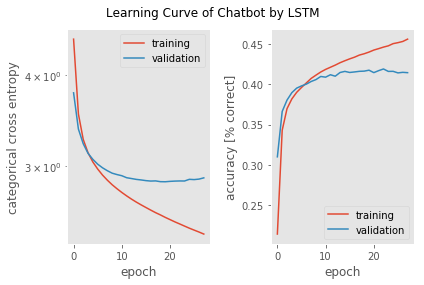

In [69]:
plot_history(history_chatbot, 'Learning Curve of Chatbot by LSTM')

## Answer generation with sampling temperatures

In [70]:
Chatbot = load_model("Chatbox_LSTM")

In [71]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [72]:
def recover_qa(temp_qa):
    original_q=[]
    original_a=[]
    temp_q, temp_a=temp_qa
    for temp_index in temp_q:
        orignal_q_word=inv_qa_word_dict[temp_index]
        if temp_index!=0:
            original_q=original_q+[orignal_q_word]
    for temp_index in temp_a:
        orignal_a_word=inv_qa_word_dict[temp_index]
        if temp_index!=0:
            original_a=original_a+[orignal_a_word]
    return [original_q,original_a]
def recover_answer(new_answer):
    original_answer=[]
    for temp_index in new_answer:
        orignal_word=inv_qa_word_dict[temp_index]
        if temp_index!=0:
            original_answer=original_answer+[orignal_word]
    return original_answer

In [34]:
def generate_answers(init_quest_answ,temperature_1=0.5,temperature_2=1,model=Chatbot,start=1):
    init_quest=init_quest_answ[0][:-1]
    init_quest=np.array(init_quest)
    init_quest=init_quest.reshape((1,maxlen-1))
    original_init_quest,original_init_answ=recover_qa(init_quest_answ)
    init_answ=init_quest_answ[1]
    print('Initial Context:')
    print(original_init_quest)
    print('Initial Answer: ')
    print(original_init_answ)
    print('With Temperature '+str(temperature_1))
    for i in range(1):
        init_quest
        temp_answer=[qa_word_dict['START']]+(maxlen-2)*[qa_word_dict['PADD']]
        temp_answer=np.array(temp_answer)
        temp_answer=temp_answer.reshape((1,maxlen-1))
        for word_index in range(start,maxlen-1):
            temp_input=np.array([init_quest,temp_answer])
            #print(temp_input[1].shape)
            temp_pred=model.predict([init_quest,temp_answer])
            temp_word_token=sample(temp_pred[0][word_index],temperature=temperature_1)
            temp_answer[0][word_index]=temp_word_token
        pred_answer=recover_answer(temp_answer[0])
        print('Predicted Answer: ')
        print(pred_answer)
    print('With Temperature '+str(temperature_2))
    for i in range(1):
        init_quest
        temp_answer=[qa_word_dict['START']]+(maxlen-2)*[qa_word_dict['PADD']]
        temp_answer=np.array(temp_answer)
        temp_answer=temp_answer.reshape((1,maxlen-1))
        for word_index in range(start,maxlen-1):
            temp_input=np.array([init_quest,temp_answer])
            #print(temp_input[1].shape)
            temp_pred=model.predict([init_quest,temp_answer])
            temp_word_token=sample(temp_pred[0][word_index],temperature=temperature_2)
            temp_answer[0][word_index]=temp_word_token
        pred_answer=recover_answer(temp_answer[0])
        print('Predicted Answer: ')
        print(pred_answer)

In [36]:
import random
np.random.seed(seed)
maxlen=25
for i in range(10):
    print('Sample '+str(i))
    temp_init_quest_answ =random.sample(token_quest_answ, 1)[0]
    generate_answers(temp_init_quest_answ,temperature_1=0.5,temperature_2=1,model=Chatbot,start=1)
    print('-----------------------------------------------------------------')

Sample 0
Initial Context:
['very', 'well', ',', 'thank', 'you', '.', 'where', 'do', 'you', 'live', '?', 'i', 'am', 'from', 'ireland']
Initial Answer: 
['START', 'i', 'am', 'in', 'new', 'york', '.', 'what', 'is', 'ireland', 'like', '?', 'END']
With Temperature 0.5
Predicted Answer: 
['START', 'i', 'am', 'in', 'the', 'north', '.', 'i', 'am', 'a', 'little', 'lonely', 'END']
With Temperature 1
Predicted Answer: 
['START', 'i', 'work', 'at', 'a', 'restaurant', '.', 'been', 'military', 'since', 'i', 'am', 'on', 'my', 'diet', ',', 'red', '.', '.', '.', 'dragons', '?', 'END']
-----------------------------------------------------------------
Sample 1
Initial Context:
['i', 'am', 'usually', 'not', 'very', 'creative', 'in', 'the', 'kitchen', ',', 'but', 'will', 'look', 'him', 'up']
Initial Answer: 
['START', 'he', 'is', 'great', '.', 'i', 'think', 'you', 'will', 'like', 'him', '.', 'END']
With Temperature 0.5
Predicted Answer: 
['START', 'i', 'do', 'not', 'have', 'any', '.', 'i', 'love', 'all', '

In [73]:
def generate_10_answers(init_quest_answ,temperature=1,model=Chatbot,start=1):
    init_quest=init_quest_answ[0][:-1]
    init_quest=np.array(init_quest)
    init_quest=init_quest.reshape((1,maxlen-1))
    original_init_quest,original_init_answ=recover_qa(init_quest_answ)
    init_answ=init_quest_answ[1]
    print('Initial Context:')
    print(original_init_quest)
    print('Initial Answer: ')
    print(original_init_answ)
    print('With Temperature '+str(temperature))
    for i in range(10):
        init_quest
        temp_answer=[qa_word_dict['START']]+(maxlen-2)*[qa_word_dict['PADD']]
        temp_answer=np.array(temp_answer)
        temp_answer=temp_answer.reshape((1,maxlen-1))
        for word_index in range(start,maxlen-1):
            temp_input=np.array([init_quest,temp_answer])
            #print(temp_input[1].shape)
            temp_pred=model.predict([init_quest,temp_answer])
            temp_word_token=sample(temp_pred[0][word_index],temperature=temperature)
            temp_answer[0][word_index]=temp_word_token
        pred_answer=recover_answer(temp_answer[0])
        print("Sample "+str(i+1))
        print('Predicted Answer: ')
        print(pred_answer)

In [87]:
import random
np.random.seed(seed)
init_quest_answ_1, init_quest_answ_2 =random.sample(token_quest_answ, 2)
maxlen=25
generate_10_answers(init_quest_answ_1, temperature=0.5)

Initial Context:
['hello', ',', 'how', 'are', 'you', 'doing', 'tonight', '?']
Initial Answer: 
['START', 'i', 'm', 'doing', 'great', 'how', 'about', 'you', '?', 'END']
With Temperature 0.5
Sample 1
Predicted Answer: 
['START', 'i', 'am', 'doing', 'great', '!', 'just', 'watching', 'some', 'movies', '.', 'you', '?', 'END']
Sample 2
Predicted Answer: 
['START', 'i', 'am', 'doing', 'pretty', 'good', '.', 'how', 'about', 'you', '?', 'END']
Sample 3
Predicted Answer: 
['START', 'i', 'am', 'great', ',', 'just', 'got', 'back', 'from', 'the', 'gym', '.', 'how', 'are', 'you', '?', 'END']
Sample 4
Predicted Answer: 
['START', 'i', 'am', 'doing', 'well', '.', 'how', 'are', 'you', '?', 'END']
Sample 5
Predicted Answer: 
['START', 'i', 'am', 'doing', 'well', ',', 'just', 'finished', 'my', 'daily', 'run', '.', 'you', '?', 'END']
Sample 6
Predicted Answer: 
['START', 'i', 'am', 'doing', 'well', '.', 'how', 'are', 'you', '?', 'END']
Sample 7
Predicted Answer: 
['START', 'i', 'am', 'doing', 'well', '.',

In [89]:
generate_10_answers(init_quest_answ_2, temperature=1.0)

Initial Context:
['i', 'i', 'was', 'but', 'my', 'wife', 'left', 'me', 'when', 'i', 'was', 'in', 'the', 'military']
Initial Answer: 
['START', 'i', 'am', 'sorry', 'to', 'hear', 'that', 'END']
With Temperature 1.0
Sample 1
Predicted Answer: 
['START', 'happy', 'birthday', '!', 'where', 'are', 'you', 'from', '?', 'END']
Sample 2
Predicted Answer: 
['START', 'i', 'met', 'him', 'to', 'research', 'there', 'but', 'can', 'END']
Sample 3
Predicted Answer: 
['START', 'oh', '.', 'do', 'you', 'have', 'any', 'hobbies', '?', 'END']
Sample 4
Predicted Answer: 
['START', 'that', 'is', 'great', '!', 'at', 'the', 'world', 'you', 'workout', 'during', 'there', '?', 'END']
Sample 5
Predicted Answer: 
['START', 'i', 'have', 'two', 'dogs', '.', 'i', 'travel', 'of', 'work', '.', 'i', 'am', 'love', 'dogs', '!', '!', '!', '!', 'END']
Sample 6
Predicted Answer: 
['START', 'so', 'what', 'do', 'you', 'do', 'for', 'a', 'living', '?', 'END']
Sample 7
Predicted Answer: 
['START', 'i', 'am', 'sorry', 'to', 'hear', 'th

## Bonus: Chatbot discusses with itself

In [77]:
def chatbot_discuss_with_itself(init_quest,num_answer, temperature=1,model=Chatbot,start=1):
    #print('With Temperature '+str(temperature))
    original_init_quest=recover_answer(init_quest)
    print(original_init_quest)
    temp_quest=init_quest.copy()
    temp_quest=np.array(temp_quest[:-1])
    temp_quest=temp_quest.reshape((1,maxlen-1))
    for i in range(num_answer):
        
        temp_answer=[qa_word_dict['START']]+(maxlen-2)*[qa_word_dict['PADD']]
        temp_answer=np.array(temp_answer)
        temp_answer=temp_answer.reshape((1,maxlen-1))
        for word_index in range(start,maxlen-1):
            temp_input=np.array([temp_quest,temp_answer])
            temp_pred=model.predict([temp_quest,temp_answer])
            temp_word_token=sample(temp_pred[0][word_index],temperature=temperature)
            temp_answer[0][word_index]=temp_word_token
        pred_answer=recover_answer(temp_answer[0])
        temp_quest=np.array(temp_answer.copy())
        temp_quest=temp_quest[0]
        temp_quest=temp_quest.reshape((1,maxlen-1))
        print(pred_answer)

In [81]:
import random
np.random.seed(seed)
initial_quest_answ=random.sample(token_quest_answ, 1)
initial_quest=initial_quest_answ[0][0]
chatbot_discuss_with_itself(initial_quest,20,temperature=1)

['blue', 'is', 'pretty', '!', 'what', 'do', 'you', 'do', 'for', 'a', 'living', '?']
['START', 'i', 'am', 'in', 'fashion', 'right', 'now', 'so', 'i', 'am', 'in', 'school', 'END']
['START', 'cool', ',', 'what', 'do', 'you', 'do', 'for', 'fun', '?', 'END']
['START', 'about', 'to', 'go', 'with', 'a', 'hockey', 'team', '.', 'END']
['START', 'does', 'yoga', 'in', 'the', 'odd', 'only', 'motorcycle', 'END']
['START', 'i', 'just', 'got', 'a', 'stay', 'in', 'a', 'concert', '.', 'i', 'am', 'studying', 'to', 'watch', 'any', 'sports', '.', 'END']
['START', 'its', 'a', 'bummer', '.', 'do', 'you', 'work', '?', 'END']
['START', 'i', 'wish', 'i', 'was', '.', 'my', 'allergies', 'are', 'quick', 'so', 'now', '.', 'END']
['START', 'oh', 'i', 'hope', 'to', 'open', 'it', 'you', '.', 'END']
['START', 'yeah', 'i', 'thought', 'you', 'are', 'thinking', 'about', 'pop', '.', 'END']
['START', 'haha', '.', 'i', 'am', 'working', 'out', '.', 'just', 'started', 'teaching', '.', 'my', 'folks', 'are', 'five', 'years', 'f

The performance of discussion can be improved by taking into account many training data.